In [1]:
import numpy as np
import pickle
from glob import glob 
import os
import sys
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
import re
from src.cmos_plotter.Firing_metric_plotter import *

In [6]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_stimulation/Full_dataset/Full_firing_files'

In [3]:
filename = 'ID2184_N5_DIV7_DATE20250321_1210_spontaneous_reseed.raw_processed.pkl'
data = pickle.load(open(os.path.join(MAIN_PATH, f'Sorters/{filename}'), 'rb'))
print(data.keys())

dict_keys(['CHIP_ID', 'NW_ID', 'DIV', 'EXPERIMENT_DURATION', 'SPIKEMAT_EXTREMUM', 'SPIKEMAT', 'UNIT_TO_EL', 'BLANKING'])


In [4]:
data['SPIKEMAT']

array([('12273', 1.65, -91.24955811), ('11157', 1.65, -62.74821677),
       ('9621', 1.65, -45.27802456), ..., ('6768', 1.7 , -71.34810977),
       ('21509', 1.65, -51.20591146), ('18643', 1.55, -78.51322766)],
      dtype=[('Electrode', '<U10'), ('Spike_Time', '<f8'), ('Amplitude', '<f8')])

In [7]:
# Find all pickle files
pickle_files = glob(os.path.join(MAIN_PATH,"*.pkl"))
print(pickle_files)

# Initialize lists for both types of results
all_extremum_results = []
all_spikemat_results = []

# Process each file
for file in pickle_files:
    print(f"Processing {file}...")
    extremum_results, spikemat_results = process_spike_data(file)
    all_extremum_results.extend(extremum_results)
    all_spikemat_results.extend(spikemat_results)


['/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_stimulation/Full_dataset/Full_firing_files/ID2184_5_DIV41_DATE20250424_1331_spontaneous_FreqVarDel5V2_.raw_processed.pkl', '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_stimulation/Full_dataset/Full_firing_files/ID2167_6_DIV41_DATE20250424_1438_spontaneous_FreqVarDel5V2_10Hz.raw_processed.pkl', '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_stimulation/Full_dataset/Full_firing_files/ID2816_0_DIV41_DATE20250424_1525_spontaneous_FreqVarDel0V2_20Hz.raw_processed.pkl', '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/biTE_stimulation/Full_dataset/Full_firing_files/ID2816_0_DIV41_DATE20250424_1437_spontaneous_FreqVarDel0V2_10Hz_0.raw_processed.pkl', '/itet-stor/kvulic/neuronies/single_neurons/1

In [8]:
#save to pickle
with open(os.path.join(MAIN_PATH,'all_extremum_results.pkl'), 'wb') as f:
    pickle.dump(all_extremum_results, f)
with open(os.path.join(MAIN_PATH,'all_spikemat_results.pkl'), 'wb') as f:
    pickle.dump(all_spikemat_results, f)

In [7]:
pd.DataFrame(all_extremum_results).keys()

Index(['filename', 'chip_id', 'area', 'div', 'electrode', 'unit_idx',
       'unit_id', 'data_type', 'firing_rate', 'isi_mean', 'isi_median',
       'isi_std', 'isi_cv', 'burst_index', 'spike_count'],
      dtype='object')

In [12]:
save_path = os.path.join(MAIN_PATH, 'Results')
specific_div = 35
extremum = True
electrode = True
# Create output directory for plots and saved files
output_dir = save_path if save_path else "."
plots_dir = os.path.join(output_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# Set the DIV for box plots
box_plot_div = specific_div if specific_div is not None else 28

# File paths for unit-level data
unit_pkl_file = os.path.join(output_dir, 'combined_unit_metrics.pkl')
unit_csv_file = os.path.join(output_dir, 'combined_unit_metrics.csv')

# File paths for electrode-level data
electrode_pkl_file = os.path.join(output_dir, 'combined_electrode_metrics.pkl')
electrode_csv_file = os.path.join(output_dir, 'combined_electrode_metrics.csv')


# Process SPIKEMAT_EXTREMUM results (unit-level)
if extremum:
    if not (os.path.exists(unit_pkl_file) and os.path.exists(unit_csv_file)):
        df_extremum = pd.DataFrame(all_extremum_results)
        print(f"Processed {len(df_extremum)} units from SPIKEMAT_EXTREMUM data.")
        
        # Save combined data to new pickle file
        with open(unit_pkl_file, 'wb') as f:
            pickle.dump(df_extremum, f)
        print(f"Unit-level data saved to '{unit_pkl_file}'")
        
        # Save as CSV for easy viewing
        df_extremum.to_csv(unit_csv_file, index=False)
        print(f"Unit-level data also saved to '{unit_csv_file}'")
    else:
        df_extremum = pd.read_pickle(unit_pkl_file)
        print(f"Unit-level data loaded from '{unit_pkl_file}'")
    
    # Generate combined subplot for all metrics
    create_combined_div_plot(df_extremum, "unit", plots_dir)
    
    # Generate box plots for specified DIV
    create_specific_div_boxplot(df_extremum, box_plot_div, "unit", plots_dir)
else:
    print("No unit-level (SPIKEMAT_EXTREMUM) data processed.")

# Process SPIKEMAT results (electrode-level)
if electrode:
    if not (os.path.exists(electrode_pkl_file) and os.path.exists(electrode_csv_file)):
        df_spikemat = pd.DataFrame(all_spikemat_results)
        print(f"Processed {len(df_spikemat)} electrodes from SPIKEMAT data.")
        
        # Save combined data to new pickle file
        with open(electrode_pkl_file, 'wb') as f:
            pickle.dump(df_spikemat, f)
        print(f"Electrode-level data saved to '{electrode_pkl_file}'")
        
        # Save as CSV for easy viewing
        df_spikemat.to_csv(electrode_csv_file, index=False)
        print(f"Electrode-level data also saved to '{electrode_csv_file}'")
    else:
        df_spikemat = pd.read_pickle(electrode_pkl_file)
        print(f"Electrode-level data loaded from '{electrode_pkl_file}'")
    
    # Generate combined subplot for all metrics
    create_combined_div_plot(df_spikemat, "electrode", plots_dir)
    
    # Generate box plots for specified DIV
    create_specific_div_boxplot(df_spikemat, box_plot_div, "electrode", plots_dir)
else:
    print("No electrode-level (SPIKEMAT) data processed.")

Unit-level data loaded from '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results/combined_unit_metrics.pkl'
Saved /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results/plots/unit_combined_metrics_by_div.png
No data available for DIV35.
Electrode-level data loaded from '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results/combined_electrode_metrics.pkl'
Saved /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results/plots/electrode_combined_metrics_by_div.png
No data available for DIV35.


In [ ]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/'
save_path = os.path.join(MAIN_PATH, 'Results')
with open(os.path.join(save_path, 'combined_unit_metrics.pkl'), 'rb') as f:
    df_extremum = pd.DataFrame(pickle.load(f))
df_extremum['area'] =  df_extremum['area'].astype(float)
df_1 = df_extremum


In [20]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/'
save_path = os.path.join(MAIN_PATH, 'biTE_stimulation/Full_dataset/Full_firing_files')
with open(os.path.join(save_path, 'all_extremum_results.pkl'), 'rb') as f:
    df_extremum = pd.DataFrame(pickle.load(f))
df_extremum['area'] =  df_extremum['area'].astype(float)
df_extremum

,filename,chip_id,area,div,electrode,unit_idx,unit_id,data_type,firing_rate,isi_mean,isi_median,isi_std,isi_cv,burst_index,spike_count
0,ID2184_5_DIV41_DATE20250424_1331_spontaneous_F...,2184,5.0,41,16671,5,7,SPIKEMAT_EXTREMUM,1.960167,511.849834,328.325,1480.636042,2.892716,1.558973,303
1,ID2184_5_DIV41_DATE20250424_1331_spontaneous_F...,2184,5.0,41,22155,57,62,SPIKEMAT_EXTREMUM,3.008299,333.130172,71.050,543.261984,1.630780,4.688672,465
2,ID2184_5_DIV41_DATE20250424_1331_spontaneous_F...,2184,5.0,41,4341,34,38,SPIKEMAT_EXTREMUM,1.413369,710.789862,376.900,976.465246,1.373775,1.885884,218
3,ID2184_5_DIV41_DATE20250424_1331_spontaneous_F...,2184,5.0,41,2353,14,17,SPIKEMAT_EXTREMUM,4.483135,223.381449,80.050,820.572401,3.673413,2.790524,691
4,ID2184_5_DIV41_DATE20250424_1331_spontaneous_F...,2184,5.0,41,24368,56,61,SPIKEMAT_EXTREMUM,1.270899,790.900515,615.450,716.492079,0.905919,1.285077,195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12234,ID2816_1_DIV35_DATE20250418_1552_spontaneous_F...,2816,1.0,35,701,20,28,SPIKEMAT_EXTREMUM,2.547851,393.283773,75.300,2331.530279,5.928366,5.222892,494
12235,ID2816_1_DIV35_DATE20250418_1552_spontaneous_F...,2816,1.0,35,703,22,30,SPIKEMAT_EXTREMUM,0.755317,1332.434615,703.825,1888.399701,1.417255,1.893133,157
12236,ID2816_1_DIV35_DATE20250418_1552_spontaneous_F...,2816,1.0,35,24675,5,5,SPIKEMAT_EXTREMUM,1.759702,569.964392,62.350,3138.907783,5.507200,9.141370,338
12237,ID2816_1_DIV35_DATE20250418_1552_spontaneous_F...,2816,1.0,35,25341,8,11,SPIKEMAT_EXTREMUM,0.796929,1262.709119,164.900,2286.992932,1.811180,7.657423,160


/tmp/ipykernel_22714/2048736237.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


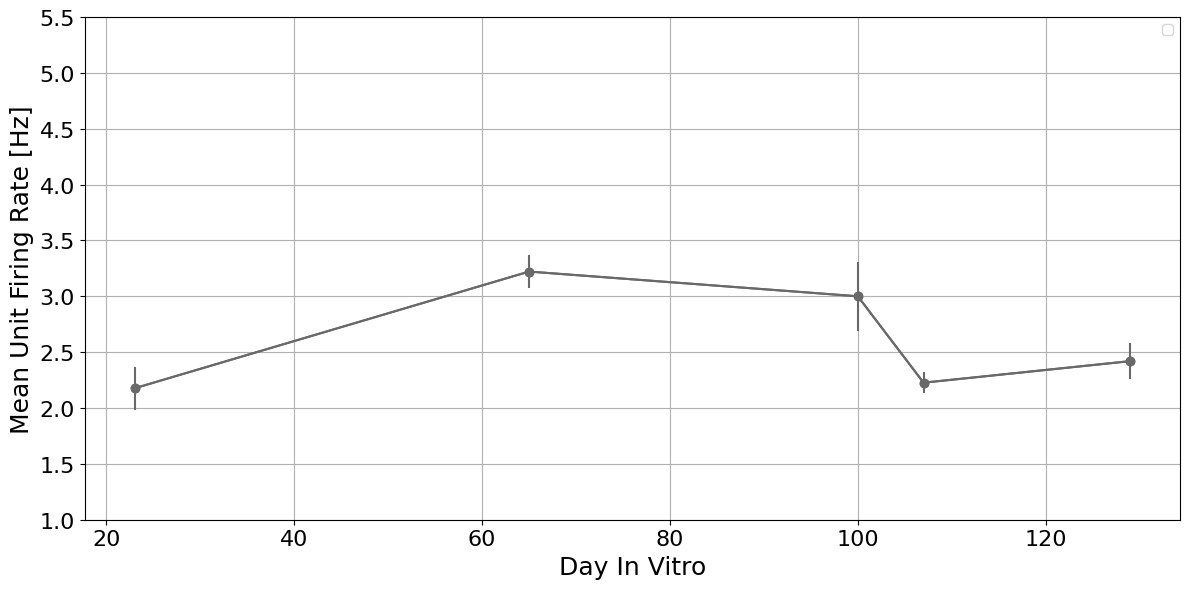

In [8]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

#remove rows with div == 98 from df_extremum
#df_extremum = df_extremum[df_extremum['area'].isin([1])]

df_extremum = df_extremum[df_extremum['div'] > 10]
df_extremum = df_extremum[df_extremum['div'] != 35]
#df_extremum = df_extremum[df_extremum['div'].isin([23, 65, 107, 129, 147])]



# Calculate mean and SEM for firing_rate grouped by div
grouped = df_extremum.groupby('div')['firing_rate']
mean_firing_rate = grouped.mean()
std_firing_rate = grouped.std()
#calculate standard error of the mean
sem_firing_rate = grouped.std() / np.sqrt(grouped.count())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(mean_firing_rate.index, mean_firing_rate, color='dimgrey')
plt.errorbar(mean_firing_rate.index, mean_firing_rate, yerr=sem_firing_rate, fmt='-o', color='dimgrey')
plt.scatter(mean_firing_rate.index, mean_firing_rate, color='dimgrey')

#plt.title('Mean Firing Rate per DIV')
plt.xlabel('Day In Vitro', fontsize=18)
plt.ylabel('Mean Unit Firing Rate [Hz]', fontsize=18)
plt.ylim(1,5.5)
#increase fontsize on x and y
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'plots/Mean_Firing_Rate_per_DIV.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'plots/Mean_Firing_Rate_per_DIV.pdf'), format = 'pdf', dpi=300)


plt.show()


In [4]:
def custom_lineplot(data, x_metric, y_metric, axes, label, fontsize=16, labelsize=14, xlim = None, ylim = None, save_path=None):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'    
    sns.lineplot(data=data, x=x_metric, y=y_metric, color="dimgrey", markers=True, estimator="mean", 
                 err_style="bars", legend=True, zorder=1, ax=axes, dashes=False, marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))        
    axes.set_ylabel(label, fontsize=fontsize)    
    axes.set_xlabel("Day In Vitro", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    if save_path:
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'{label[:-3]}.pdf'), dpi=300)
    

In [5]:
save_path = os.path.join(MAIN_PATH, 'Results')
df_extremum = df_extremum[df_extremum['div'].isin([23, 65, 107, 129, 147])]
df_extremum.keys()

Index(['chip_id', 'area', 'div', 'electrode', 'unit_idx', 'data_type',
       'firing_rate', 'isi_mean', 'isi_median', 'isi_std', 'isi_cv',
       'burst_index', 'spike_count'],
      dtype='object')

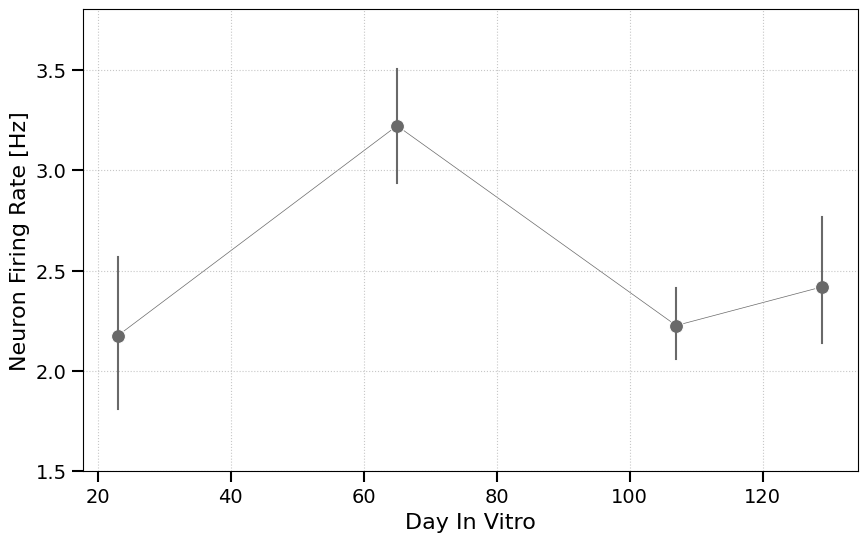

In [6]:

fig, ax = plt.subplots(figsize=(10,6))
custom_lineplot(df_extremum, df_extremum['div'], df_extremum['firing_rate'], ax, label = 'Neuron Firing Rate [Hz]', fontsize=16, labelsize=14, xlim = None, ylim = (1.5,3.8), save_path = save_path)      

In [16]:
def multi_dataframe_lineplot(data_list, x_metrics, y_metrics, axes, labels, colors, fontsize=16, labelsize=14, xlim=None, ylim=None, save_path=None, log_scale=False):
    plt.rcParams['xtick.bottom'] = True    
    plt.rcParams['ytick.left'] = True    
    plt.rcParams['font.family'] = 'Arial'
    
    # Plot each dataframe with its own color
    for data, x_metric, y_metric, label, color in zip(data_list, x_metrics, y_metrics, labels, colors):
        sns.lineplot(data=data, x=x_metric, y=y_metric, color=color, markers=True, estimator="mean", 
                    err_style="bars", label=label, zorder=1, ax=axes, dashes=False, 
                    marker="o", ms=10, linewidth=0.5, errorbar=("ci", 95))
    
    # Set common axes properties
    axes.set_ylabel(labels[0], fontsize=fontsize)  # Using the first label for y-axis title
    axes.set_xlabel("Log (Day In Vitro)", fontsize=fontsize)    
    axes.grid(True, linestyle=':', alpha=0.7)    
    axes.tick_params(axis='both', which='major', labelsize=labelsize, width=1.5, length=8)
    axes.legend()
    
    if log_scale:
        axes.set_xscale('log')  # Set x-axis to log scale
    

    if xlim is not None:
        axes.set_xlim(xlim)
    if ylim is not None:
        axes.set_ylim(ylim)
    
    if save_path:
        plt.savefig(os.path.join(save_path, f'firing_rate_combined.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'firing_rate_combined.pdf'), dpi=300)

In [17]:
save_path

'/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Results'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

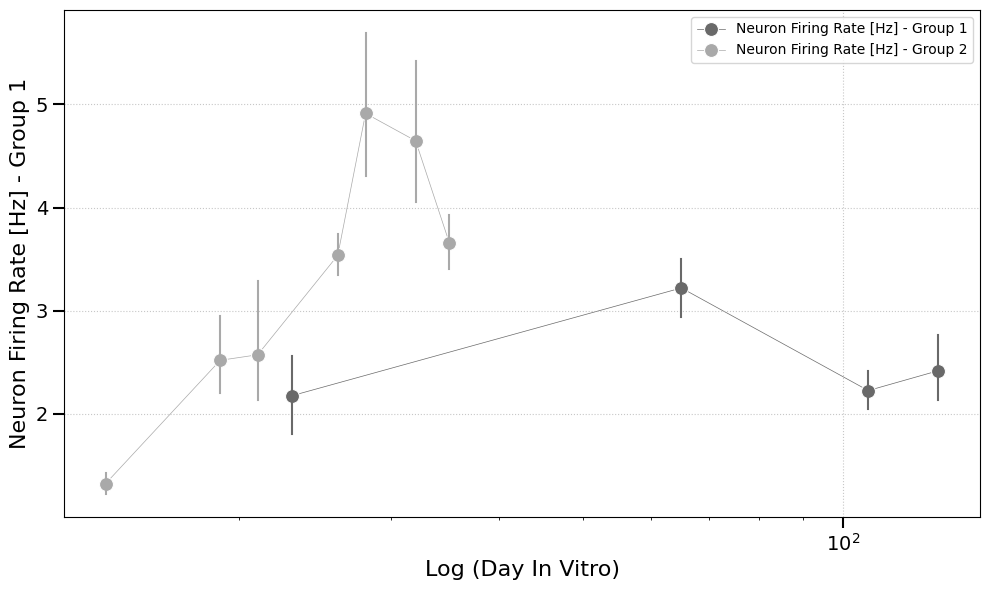

In [18]:
# Filter data if needed (like in your example with speeds)
df_1 = pd.DataFrame(df_1)
df_2 = pd.DataFrame(df_2)
df_2 = df_2[df_2['div'] > 10]
df_1 = df_1[df_1['div'].isin([23, 65, 107, 129, 147])]

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors - dimgray for first and a lighter gray for second
colors = ['dimgray', '#A9A9A9']  # dimgray and darkgray

# Call the modified function with both dataframes
multi_dataframe_lineplot(
    data_list=[df_1, df_2],
    x_metrics=[df_1['div'], df_2['div']],
    y_metrics=[df_1['firing_rate'], df_2['firing_rate']],
    axes=ax,
    labels=['Neuron Firing Rate [Hz] - Group 1', 'Neuron Firing Rate [Hz] - Group 2'],
    colors=colors,
    fontsize=16, 
    labelsize=14, 
    xlim=None, 
    #ylim=(0.35, 0.8), 
    save_path=save_path,
    log_scale=True
)

plt.tight_layout()
plt.show()

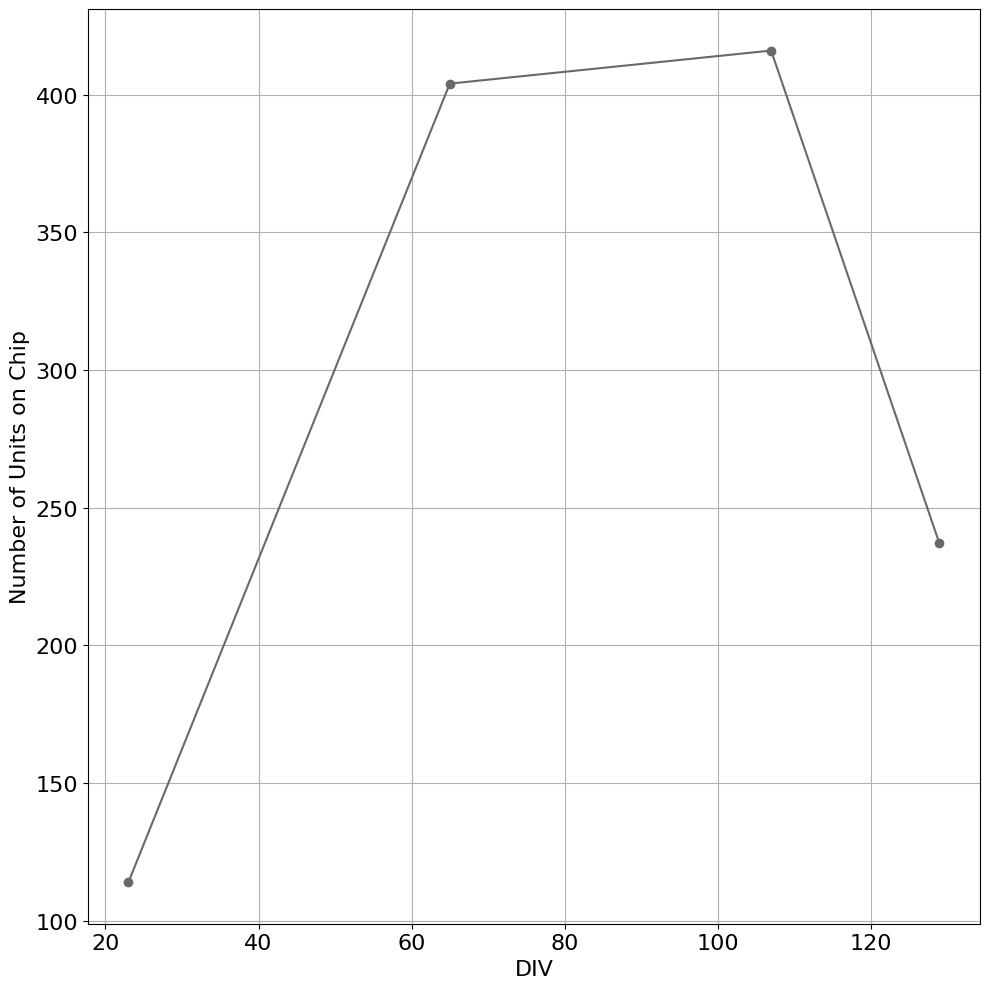

In [20]:
# Summarize the number of units per chip for each DIV
#leave only until div 42
#df_extremum = df_extremum[df_extremum['div'] <= 42]


units_per_div = df_extremum.groupby(['chip_id', 'div']).size().reset_index(name='unit_count')

# Plot the number of units vs DIV
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for chip_id, group in units_per_div.groupby('chip_id'):
    plt.plot(group['div'], group['unit_count'], marker='o', color = 'dimgrey')

plt.xlabel('DIV', fontsize=16)
plt.ylabel('Number of Units on Chip', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0, 450)
#plt.legend(title='Chip ID')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_path, 'plots/Number_of_units_per_DIV.png'), dpi=300)
plt.savefig(os.path.join(save_path, 'plots/Number_of_units_per_DIV.pdf'), format = 'pdf', dpi=300)
plt.show()





In [8]:
import pickle 
with open('/itet-stor/kvulic/neuronies/single_neurons/3_Student_Projects/Amelie/Processed_data/Amelie_analysis/Chip1908/Chip1908_DIV42/ID1908_N1_DIV42_DATE20241204_1552_spontaneous_NGN2.raw_processed.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
data

{'CHIP_ID': 1908,
 'NW_ID': 1,
 'DIV': 42,
 'EXPERIMENT_DURATION': 77.81,
 'SPIKEMAT_EXTREMUM': array([('1204', 5.50000e-01, 572), ('2534', 2.60000e+00, 619),
        ('1845', 8.35000e+00, 118), ..., ('1432', 7.78068e+04, 703),
        ('9341', 7.78088e+04, 501), ('7366', 7.78096e+04, 801)],
       dtype=[('Electrode', '<U10'), ('Spike_Time', '<f8'), ('Unit_Id', '<i4')]),
 'SPIKEMAT': array([('1204', 4.000000e-01, -37.82762146),
        ('6466', 1.800000e+00,  -9.07563591),
        ('8045', 1.800000e+00,  -9.07553291), ...,
        ('6924', 7.780960e+04, -15.69234848),
        ('546', 7.780975e+04, -16.45264244),
        ('766', 7.780975e+04, -17.45593643)],
       dtype=[('Electrode', '<U10'), ('Spike_Time_ms', '<f8'), ('Amplitude_uV', '<f8')]),
 'UNIT_TO_EL': {1: [8268,
   8710,
   8045,
   8706,
   9148,
   7826,
   9149,
   8488,
   8708,
   7609,
   8930,
   8265,
   8709,
   8929,
   7825,
   8927,
   8266,
   7605,
   8047,
   4526,
   3426,
   8485,
   8489,
   3646,
   4746],


In [8]:
import glob
pickle_files = glob.glob(os.path.join(MAIN_PATH, "biTE_new/*_metrics.pkl"))

In [9]:
import os
import pickle
import pandas as pd
import re


# Create an empty list to store all the dataframes
all_data = []
output_file = "combined_results.pkl" 

for file_path in pickle_files:
    # Extract filename without path
    filename = os.path.basename(file_path)
    #take filename string until 'raw' and add '.h5'
    filename_add_h5 = filename.split('raw')[0] + 'raw.h5'

    
    # Extract metadata from filename using regex
    match = re.match(r'ID(\d+)_N(\d+)_DIV(\d+)_.*\.pkl', filename)
    
    if match:
        chip_id = match.group(1)
        area = match.group(2)
        div = match.group(3)
        
        try:
            # Load the pickle file
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
            
            # Check if 'validated_results' exists in the data
            if 'validated_results' in data:
                # Extract the needed columns
                results = pd.DataFrame(data['validated_results'])
                
                # Make sure it has the required columns
                if all(col in results.columns for col in ['syn probability', 'source_unit_id', 'target_unit_id', 'lag', 'validation']):
                    # Filter rows where validation is 'good'
                    filtered_results = results[results['validation'] == 'good']
                    #check if syn probability is not NaN
                    filtered_results = filtered_results[filtered_results['syn probability'].notna()]
                    
                    # Create a subset with just the columns we want
                    subset = filtered_results[['syn probability', 'source_unit_id', 'target_unit_id', 'lag']].copy()
                    
                    # Add the metadata columns
                    subset['chip_id'] = chip_id
                    subset['area'] = area
                    subset['div'] = div
                    subset['filename'] = filename_add_h5
                    
                    # Append to our list of dataframes
                    all_data.append(subset)
                    print(f"Processed {filename} - added {len(subset)} rows")
                else:
                    print(f"Warning: {filename} is missing required columns")
            else:
                print(f"Warning: {filename} doesn't have 'validated_results'")
        except Exception as e:
            print(f"Error processing {filename}: {e}")
    else:
        print(f"Warning: Could not parse metadata from filename: {filename}")

# Combine all dataframes
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Save the combined dataframe to a new pickle file
    combined_df.to_pickle(os.path.join(MAIN_PATH, 'biTE_new/combined_results_probability.pkl'))
    
    print(f"Successfully created {output_file} with {len(combined_df)} rows")
    print(f"Data columns: {combined_df.columns.tolist()}")
else:
    print("No valid data found. Combined file was not created.")

Processed ID2167_N6_DIV35_DATE20250418_1614_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 98 rows
Processed ID2167_N1_DIV19_DATE20250402_1301_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 0 rows
Processed ID2816_N8_DIV32_DATE20250415_0917_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 19 rows
Processed ID2184_N2_DIV14_DATE20250328_0906_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 1 rows
Processed ID2751_N3_DIV19_DATE20250402_1302_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 2 rows
Processed ID2816_N1_DIV21_DATE20250404_1107_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 2 rows
Processed ID2167_N5_DIV26_DATE20250409_1028_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 9 rows
Processed ID2816_N2_DIV19_DATE20250402_1220_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 6 rows
Processed ID2751_N0_DIV21_DATE20250404_1147_spontaneous_NGN2.raw_processed_info_metrics.pkl - added 0 rows
Processed ID2167_N5_DIV32_DATE20250

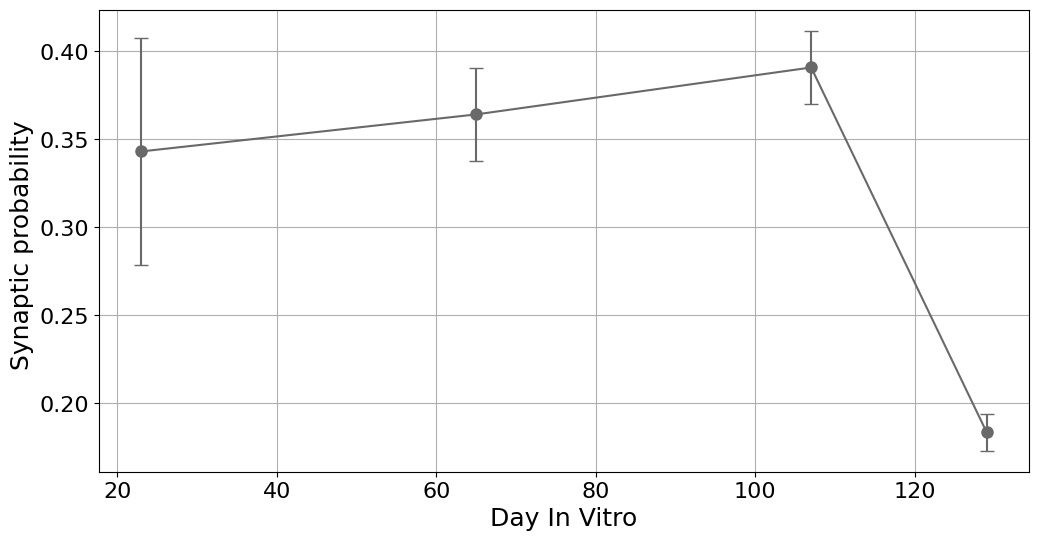

In [29]:




plt.figure(figsize=(12, 6))

combined_df['div'] = combined_df['div'].astype(int)
combined_df = combined_df[combined_df['div'].isin([23, 65, 107, 129, 147])]

# Calculate SEM for each DIV group
sem = combined_df.groupby('div')['syn probability'].sem().reset_index(name='sem')
means = combined_df.groupby('div')['syn probability'].mean().reset_index(name='mean_probability')
# Merge the dataframes
plot_data = pd.merge(means, sem, on='div')

# Plot with error bars showing SEM
plt.errorbar(x=plot_data['div'], y=plot_data['mean_probability'], 
             yerr=plot_data['sem'], 
             fmt='o-', capsize=5, elinewidth=1.5, markersize=8, color = 'dimgray')

#plt.title('Conduction speed vs Div')
plt.xlabel('Day In Vitro', fontsize = 18)
plt.ylabel('Synaptic probability ', fontsize = 18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.ylim(0.3, 0.8)
plt.grid()
plt.savefig(os.path.join(MAIN_PATH, 'biTE/Results/syn_prob_vs_div.png'), dpi=300)
plt.savefig(os.path.join(MAIN_PATH, 'biTE/Results/syn_prob_vs_div.pdf'), dpi=300, format ='pdf')

plt.show()
